**LOAD LIBRARIES

In [1]:
import tensorflow as tf
tf.__version__
import numpy as np 
import collections
from collections import defaultdict
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from skimage.io import imread
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

# Remove warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/adejuwon/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**LOAD DATASET

In [2]:
all_scans_df = pd.DataFrame(dict(path = glob(os.path.join('MURA-v1.1', '*', '*', '*', '*', '*.png'))))
all_scans_df['TrainSplit'] = all_scans_df['path'].map(lambda x: x.split('/')[-5])
all_scans_df['Region'] = all_scans_df['path'].map(lambda x: x.split('/')[2])
all_scans_df['Patient'] = all_scans_df['path'].map(lambda x: x.split('/')[-3])
all_scans_df['FolderId'] = all_scans_df['path'].map(lambda x: x.split('/')[-2])
all_scans_df['Study'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[0])
all_scans_df['classes'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[-1] )
all_scans_df.sample(20)

,path,TrainSplit,Region,Patient,FolderId,Study,classes
26105,MURA-v1.1/train/XR_SHOULDER/patient00181/study...,train,XR_SHOULDER,patient00181,study1_positive,study1,positive
8231,MURA-v1.1/train/XR_HAND/patient01385/study1_ne...,train,XR_HAND,patient01385,study1_negative,study1,negative
18066,MURA-v1.1/train/XR_ELBOW/patient05281/study1_p...,train,XR_ELBOW,patient05281,study1_positive,study1,positive
39306,MURA-v1.1/train/XR_FOREARM/patient09201/study1...,train,XR_FOREARM,patient09201,study1_positive,study1,positive
11120,MURA-v1.1/train/XR_FINGER/patient04781/study1_...,train,XR_FINGER,patient04781,study1_negative,study1,negative
20697,MURA-v1.1/train/XR_SHOULDER/patient00682/study...,train,XR_SHOULDER,patient00682,study1_positive,study1,positive
33300,MURA-v1.1/train/XR_WRIST/patient08246/study1_n...,train,XR_WRIST,patient08246,study1_negative,study1,negative
6689,MURA-v1.1/train/XR_HAND/patient11023/study1_ne...,train,XR_HAND,patient11023,study1_negative,study1,negative
12892,MURA-v1.1/train/XR_FINGER/patient04616/study1_...,train,XR_FINGER,patient04616,study1_negative,study1,negative
22033,MURA-v1.1/train/XR_SHOULDER/patient02216/study...,train,XR_SHOULDER,patient02216,study1_negative,study1,negative


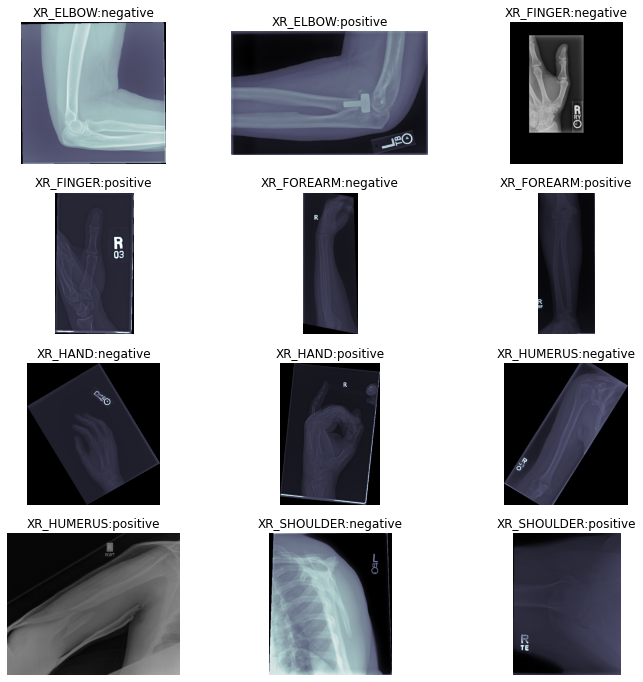

In [80]:
sub_df = all_scans_df.groupby(['Region', 'classes']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Region}:{classes}'.format(**c_row))
fig.savefig('samples.png', dpi = 300)

In [114]:

Class_count=all_scans_df.groupby(["classes"]).nunique()
Class_count

,path,TrainSplit,Region,Patient,FolderId,Study,classes
classes,,,,,,,
negative,23602,2,7,7765,4,4,1
positive,16403,2,7,5257,4,4,1


In [3]:
import numpy as np
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import cv2
import random as rd
print(tf.__version__)
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

#import tensorflow as tf
#print(tf.__version__)

2.0.0


In [281]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
%matplotlib inline 



In [290]:
import glob
dataset_root = glob.glob('/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/**/**')

In [291]:
dataset_root

['/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient02348/study1_negative',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient00847/study1_positive',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient01995/study1_negative',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient00249/study1_positive',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient01961/study1_negative',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient01539/study1_negative',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient00276/study2_positive',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient00276/study1_positive',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient02521/study1_negative',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient00878/study1_positive',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient00044/study1_positive',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient01196/study1_positive',
 '/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/patient02377/study1_negative',

In [302]:
import glob
glob.glob('/Users/adejuwon/MURA-v1.1/train/*/*')

'/Users/adejuwon/MURA-v1.1/train/XR_FOREARM/patient09179'

In [319]:
def load(root_directory,Imsize):
    import os
    pas =glob.glob('/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/*')
    #cases =["study1_positive","study1_negative"]
    cases = [('study1_positive',1),('study1_negative',0)]
    neg_images= []
    pos_images = []
    for pa in pas:
        for case in cases:
            in_dir = os.path.join(root_directory, pa, case[0])
            try:
                all_images = [f for f in os.listdir(in_dir) if f.endswith('.png')]
            except:
                continue
            if case[1] == 0:
                neg_images.extend(all_images)
            if case[1] == 1:
                pos_images.extend(all_images)
                
    return pos_images,neg_images 
            
            

In [325]:
#junk
def load(root_directory,Imsize):
    import os
    pas =glob.glob('/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/*')
    #cases =["study1_positive","study1_negative"]
    cases = [('study1_positive',1),('study1_negative',0)]
    neg_images= []
    pos_images = []
    for pa in pas:
        for case in cases:
            in_dir = os.path.join(root_directory, pa, case[0])
            try:
                all_images = [f for f in os.listdir(in_dir) if f.endswith('.png')]
            except:
                continue
            if case[1] == 0:
                neg_images.extend(all_images)
            if case[1] == 1:
                pos_images.extend(all_images)
                
    return pos_images,neg_images 
            

In [324]:
load("/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/" ,244)


(['image1.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image2.png',
  'image3.png',
  'image1.png',
  'image4.png',
  'image1.png',
  'image2.png',
  'image

In [322]:
pos_images,neg_images= load("/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/" ,244)

In [275]:
data_cat= ['train', 'valid']
study_types = list(os.walk('/Users/adejuwon/MURA-v1.1/train/'))[0][1] # study types, same for train and valid sets

patients_count = {}  # to store all patients count for each study type, for train and valid sets
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = list(os.walk('/Users/adejuwon/MURA-v1.1/%s/%s' %(phase, study_type)))[0][1] # patient folder names
        patients_count[phase][study_type] = len(patients)

In [277]:
study_count = {} # to store study counts for each study type 
for study_type in study_types:
    BASE_DIR ='/Users/adejuwon/MURA-v1.1/train/%s/'  % study_type
    study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        study_count[study_type][len(studies)] += 1

In [296]:
def load(root_directory):
    import os
    #TODO:You need to figure out how to get a list of this pa. 
    #     Your question is not clear on how to get here
    pas =glob.glob('/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/*')
    cases =["**"]
    for pa in pas:
        for case in cases:
            if case.startswith("study1"):
                in_dir = os.path.join(root_directory, pa, case)
                all_images = [f for f in os.listdir(in_dir) if f.endwith('.png')]
                for image in all_images:
                #Do your processing here
                    return f

In [297]:
load("/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/")



In [298]:
f

'study1_negative'

In [157]:
shape = (512, 512, 3)

In [158]:
data = []
labels = []

threshold = [250, 2000]

In [220]:
path = glob.glob('/Users/adejuwon/MURA-v1.1/train/XR_SHOULDER/*')


#path_positive = path + 'study1_positive'
#path_negative = path + 'study1_negative'

In [330]:
def load_rgb_data_cv(IMAGE_DIRECTORY,IMAGE_SIZE, shuffle=True):
    print("Loading images...")
    data = []
    labels=[]
    directories = next(os.walk(IMAGE_DIRECTORY))[1]

    for diretcory_name in directories:
        print("Loading {0}".format(diretcory_name))
        file_names =list(glob.iglob('/Users/adejuwon/MURA-v1.1/valid/*/*/*/*.png',recursive=True))
        #glob.glob('/Users/adejuwon/MURA-v1.1/train/*/*')
        print (file_names)
        print("we will load [", len(file_names), "] files from [",diretcory_name,"] class ..." )
        for i in range(len(file_names)):
          image_name = file_names[i]
          image_path = os.path.join(IMAGE_DIRECTORY, diretcory_name, image_name)
          #print(image_path)
          label = diretcory_name

          img = cv2.imread(next(glob.iglob("/Users/adejuwon/MURA-v1.1/valid/**/**/**/*.png", recursive=True)))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))


          #print(np.array(img).shape)
          data.append([np.array(img), label])

    if (shuffle):
      
        training_images = np.array([i[0] for i in data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
        training_labels = np.array([i[1] for i in data])
    
        print("File loading completed.")
    
    return training_images, training_labels

In [336]:
len(file_names)

2743

In [331]:
data,labels =load_rgb_data_cv('/Users/adejuwon/MURA-v1.1/valid/',244, shuffle=True)

Loading images...
Loading XR_HAND
['/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_H

Loading XR_HUMERUS
['/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient1

Loading XR_FINGER
['/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11

Loading XR_ELBOW
['/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient116

Loading XR_SHOULDER
['/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient

Loading XR_WRIST
['/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient116

Loading XR_FOREARM
['/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11212/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/patient11192/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image1.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image2.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient11393/study1_negative/image3.png', '/Users/adejuwon/MURA-v1.1/valid/XR_HUMERUS/patient1

File loading completed.


In [333]:
def plot_sample_from_dataset(images, labels,rows=5, colums=5, width=8,height=8):

  plt.figure(figsize=(width,height))
  for i in range(rows*colums):
      plt.subplot(rows,colums,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels[i])
  plt.show()

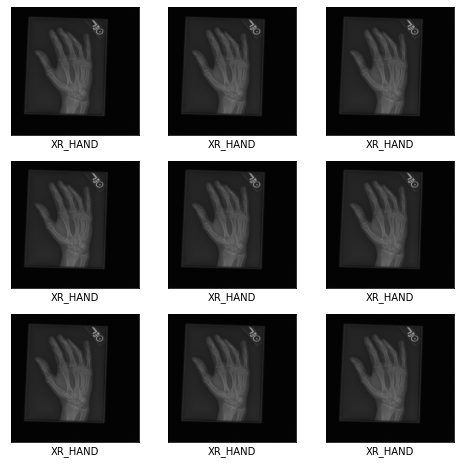

In [334]:
plot_sample_from_dataset(data, labels,rows=3, colums=3, width=8,height=8)

In [182]:
import glob
def load(root_directory,Imsize):
    import os
    #TODO:You need to figure out how to get a list of this pa. 
    #     Your question is not clear on how to get here
    pas =next(glob.iglob("/Users/adejuwon/MURA-v1.1/valid/XR_HAND/**/**/", recursive=True))

 
    cases =["study1_positive", "study1_negative"]
    for pa in pas:
        for case in cases:
            in_dir = os.path.join(root_directory, pa, case)
            all_images = [f for f in os.listdir(in_dir) if f.endswith('.png')]
            for image in all_images:
                #Do your processing here
                pass

In [187]:
    pas =next(glob.iglob("/Users/adejuwon/MURA-v1.1/valid/XR_HAND/**/**/", recursive=True))
    pas


'/Users/adejuwon/MURA-v1.1/valid/XR_HAND/'

In [ ]:

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/18Ksk-JaB-snuyApjY8OwSXSQXyXQNrr6

Mumbo Jumbo to allow working within Drive directory.
"""

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

"""Importing useful libraries."""

import numpy as np
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import cv2
import random as rd
print(tf.__version__)
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

#import tensorflow as tf
#print(tf.__version__)

"""Setting working directory and path to training examples."""

os.chdir("/content/drive/")
path = !pwd

path = path[0] + '/Colab Notebooks/CS_229/Project/Dataset/'

path_positive = path + 'train_positive'
path_negative = path + 'train_negative'

"""Defining standard image size."""

shape = (512, 512, 3)

"""Initializing X and Y."""

data = []
labels = []

threshold = [250, 2000]

"""Importing images as matrices and converting them to a 4D array.
Creating a label vector.
"""

for i in os.scandir(path_positive):
  if len(data) >= threshold[0]:
    break
  if i.is_dir():
    for j in os.scandir(i.path):
      if len(data) >= threshold[0]:
        break
      if j.is_dir():
        for k in os.scandir(j.path):
          if k.is_file:
            im = cv2.imread(k.path)
            ones = np.ones(shape, dtype=np.int32) * stats.mode(im, axis = None)[0]
            ones[:im.shape[0], :im.shape[1], :im.shape[2]] = im
            data.append(ones)
            labels.append(1)
            if len(data) >= threshold[0]:
              break
                        
for i in os.scandir(path_negative):
  if len(data) >= threshold[1]:
    break
  if i.is_dir():
    for j in os.scandir(i.path):
      if len(data) >= threshold[1]:
        break
      if j.is_dir():
        for k in os.scandir(j.path):
          if k.is_file:
            im = cv2.imread(k.path)
            ones = np.ones(shape, dtype=np.int32) * stats.mode(im, axis = None)[0]
            ones[:im.shape[0], :im.shape[1], :im.shape[2]] = im
            data.append(ones)
            labels.append(0)
            if len(data) >= threshold[1]:
              break

# converting data into 4D array                        
data = np.stack(data)
labels = np.asarray(labels)
labels = np.resize(labels, (labels.shape[0],1))

# normalizing the value of the pixels ([0,1] instead of [0,255])
data = data / 255

fixed_seed = rd.random()
rd.Random(fixed_seed).shuffle(data)
rd.Random(fixed_seed).shuffle(labels)

"""CNN model."""

model = keras.Sequential() 
model.add(layers.Conv2D(5, (3,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', padding='same', name='Conv1', input_shape=(512, 512, 3))) 
model.add(layers.Dropout(0.1, name='Dropout1')) 
model.add(layers.MaxPooling2D((2, 2), name='Pool1')) 
model.add(layers.Conv2D(7, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', padding='same', name='Conv2')) 
model.add(layers.Dropout(0.1, name='Dropout2')) 
model.add(layers.MaxPooling2D((2, 2), name='Pool2')) 
model.add(layers.Conv2D(10, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', padding='same', name='Conv3')) 
model.add(layers.Dropout(0.1, name='Dropout3')) 
model.add(layers.Flatten(name='Flatten')) 
model.add(layers.Dense(100, activation='relu', name='Dense1'))
model.add(layers.Dropout(0.4, name='Dropout4')) 
model.add(layers.Dense(100, activation='relu', name='Dense2'))
model.add(layers.Dropout(0.4, name='Dropout5')) 
model.add(layers.Dense(2, activation='relu', name='Dense3'))
model.add(layers.Dense(1, activation='sigmoid', name='Output'))

"""Plotting model."""

keras.utils.plot_model(model, 'model_with_shape_info.png', show_shapes=True)

"""Compile and train the model"""

adam = optimizers.Adam(lr=0.001)
sgd = optimizers.SGD(lr=0.0001)

model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(data, labels, epochs=10, validation_split=0.3 )

performance = model.evaluate(data, labels)
print(f'Accuracy: {performance[1]}\nLoss: {performance[0]}')

#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('$Model\ accuracy$')
plt.ylabel('$Accuracy$')
plt.xlabel('$Epoch$')
plt.legend(['$Train$', '$Val$'], loc='upper left')
plt.show()

#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('$Model\ loss$')
plt.ylabel('$Loss$')
plt.xlabel('$Epoch$')
plt.legend(['$Train$', '$Val$'], loc='upper right')
plt.show()

test_positive = path + 'test_positive'
test_negative = path + 'test_negative'

test_data = []
test_labels = []

for i in os.scandir(test_positive):
    if i.is_dir():
        for j in os.scandir(i.path):
            if j.is_dir():
                for k in os.scandir(j.path):
                    if k.is_file:
                        im = cv2.imread(k.path)
                        ones = np.ones(shape, dtype=np.int32) * stats.mode(im, axis = None)[0]
                        ones[:im.shape[0], :im.shape[1], :im.shape[2]] = im
                        test_data.append(ones)
                        test_labels.append(1)
                        
for i in os.scandir(test_negative):
    if i.is_dir():
        for j in os.scandir(i.path):
            if j.is_dir():
                for k in os.scandir(j.path):
                    if k.is_file:
                        im = cv2.imread(k.path)
                        ones = np.ones(shape, dtype=np.int32) * stats.mode(im, axis = None)[0]
                        ones[:im.shape[0], :im.shape[1], :im.shape[2]] = im
                        test_data.append(ones)
                        test_labels.append(0)

# converting data into 4D array                        
test_data = np.stack(test_data)
test_labels = np.asarray(test_labels)
test_labels = np.resize(test_labels, (test_labels.shape[0],1))

# normalizing the value of the pixels ([0,1] instead of [0,255])
test_data = test_data / 255

test_scores = model.evaluate(test_data, test_labels, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

y_pred = model.predict(test_data)

y_pred[y_pred < .5] = 0
y_pred[y_pred >= .5] = 1

confusion_matrix(test_labels, y_pred)